In [2]:
from attention_score import get_attention_and_prob
from shuffle_data import get_shuffle

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import pickle

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

c:\Users\Mai\miniconda3\envs\nlp_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define file paths
imdb_path = 'sampled_data/imdb_sampled_100.pkl'
sst2_path = 'sampled_data/sst2_sampled_100.pkl'

# Load IMDb samples
with open(imdb_path, 'rb') as f:
    imdb_samples = pickle.load(f)
    print(f"Loaded samples from: {imdb_path}")

# Load SST-2 samples
with open(sst2_path, 'rb') as f:
    sst2_samples = pickle.load(f)
    print(f"Loaded samples from: {sst2_path}")

# Convert to DataFrames
imdb_df = pd.DataFrame(imdb_samples).iloc[:50]
sst2_df = pd.DataFrame(sst2_samples).iloc[:50]

Loaded samples from: sampled_data/imdb_sampled_100.pkl
Loaded samples from: sampled_data/sst2_sampled_100.pkl


In [12]:
model_path = "D:/master/NLP/models/tinybert_sst2/final"
text = "This movie was surprisingly good!"

attn_scores, pred_prob = get_attention_and_prob(model_path, text)
print(f"Predicted class probability: {pred_prob:.4f}")
print(f"Attention scores (first 10 tokens): {attn_scores[:10]}")

Predicted class probability: 0.9934
Attention scores (first 10 tokens): [0.19777892529964447, 0.028589675202965736, 0.03700163587927818, 0.036682434380054474, 0.048674847930669785, 0.07698216289281845, 0.05220245197415352, 0.5220878720283508]


Stability

In [29]:
import torch, numpy as np, pandas as pd
from scipy.stats import spearmanr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm

def calculate_attention_stability(df, model_dir, get_shuffle, RATIOS, device=None, max_length=512, seed=42):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # load once (much faster)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True)
    model.to(device).eval()

    def get_attention_and_prob_local(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs, output_attentions=True)

        # prob of predicted class (not used in stability, but kept for parity)
        prob = softmax(outputs.logits, dim=-1).max(dim=-1).values.item()

        # mean [CLS]→token attention across layers & heads
        attn_stack = torch.stack(outputs.attentions, dim=0)      # [L, B, H, S, S]
        attn_mean  = attn_stack.mean(dim=(0, 2))                 # [B, S, S]
        cls_row    = attn_mean[0, 0, :]                          # [S]
        seq_len    = int(inputs["attention_mask"][0].sum().item())
        attn = cls_row[:seq_len].detach().cpu().tolist()
        return attn, prob

    # collect correlations
    per_ratio = {str(r): [] for r in RATIOS}

    for _, row in tqdm(df.iterrows(), total=len(df)):
        text = row["texts"]
        shuf = get_shuffle(text, RATIOS, seed=seed)          # keys: "0", "0.1", "0.2", ...
        orig_att, _ = get_attention_and_prob_local(shuf["0"])

        for r in RATIOS:
            key = str(r)
            sh_att, _ = get_attention_and_prob_local(shuf[key])
            m = min(len(orig_att), len(sh_att))
            if m == 0:
                continue
            corr, _ = spearmanr(orig_att[:m], sh_att[:m])
            if not np.isnan(corr):
                per_ratio[key].append(corr)

    # aggregate
    rows = []
    for r in RATIOS:
        vals = per_ratio[str(r)]
        if len(vals):
            rows.append({"ratio": r, "mean_spearman": float(np.mean(vals)), "std_spearman": float(np.std(vals)), "n_samples": int(len(vals))})

    df_out = pd.DataFrame(rows).sort_values("ratio").reset_index(drop=True)
    df_out.loc[len(df_out)] = {
        "ratio": "overall_mean",
        "mean_spearman": float(df_out["mean_spearman"].mean()),
        "std_spearman": float(df_out["std_spearman"].mean()),
        "n_samples": int(df_out["n_samples"].sum()),
    }
    return df_out

In [30]:
RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# Define your models and paths
model_paths = {
    "ALBERT": "D:/master/NLP/models/albert_imdb/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_imdb/final",
    "TinyBERT": "D:/master/NLP/models/tinybert_imdb/final"
}

# Collect results
all_results = []

for model_name, path in model_paths.items():
    print(f"🔹 Evaluating {model_name} ...")
    stability_df = calculate_attention_stability(
        imdb_df,
        model_dir=path,
        get_shuffle=get_shuffle,
        RATIOS=RATIOS
    )

    # keep only ratio & mean correlation columns
    model_results = stability_df[stability_df["ratio"] != "overall_mean"][["ratio", "mean_spearman"]]
    model_results["model"] = model_name
    model_results.rename(columns={"ratio": "p", "mean_spearman": "corr_spearman_mean"}, inplace=True)
    all_results.append(model_results)

# Combine everything
combined_df = pd.concat(all_results, ignore_index=True)

# Display nicely
combined_df = combined_df[["model", "p", "corr_spearman_mean"]].sort_values(["model", "p"]).reset_index(drop=True)
print(combined_df)

🔹 Evaluating ALBERT ...


100%|██████████| 50/50 [03:19<00:00,  3.99s/it]


🔹 Evaluating DistilBERT ...


100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


🔹 Evaluating TinyBERT ...


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]

         model     p  corr_spearman_mean
0       ALBERT  0.01            0.905587
1       ALBERT   0.1            0.616921
2       ALBERT   0.2            0.399152
3       ALBERT   0.3            0.342616
4       ALBERT   0.5            0.217632
5       ALBERT   0.7            0.154129
6       ALBERT   1.0            0.099962
7   DistilBERT  0.01            0.912796
8   DistilBERT   0.1            0.631058
9   DistilBERT   0.2            0.438106
10  DistilBERT   0.3            0.374934
11  DistilBERT   0.5            0.233462
12  DistilBERT   0.7            0.186695
13  DistilBERT   1.0            0.109446
14    TinyBERT  0.01            0.899521
15    TinyBERT   0.1            0.616485
16    TinyBERT   0.2            0.459296
17    TinyBERT   0.3            0.424009
18    TinyBERT   0.5            0.307074
19    TinyBERT   0.7            0.249584
20    TinyBERT   1.0            0.225581


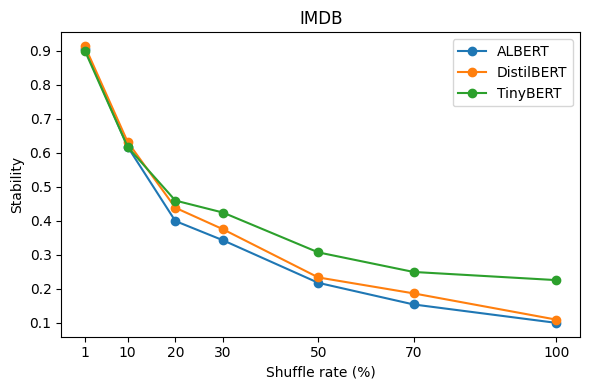

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stability_from_combined(combined_df, RATIOS, title="IMDB"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(6, 4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"] * 100, sub["corr_spearman_mean"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Shuffle rate (%)")
    plt.ylabel("Stability")
    plt.legend()
    
    # --- use RATIOS for x-ticks ---
    plt.xticks([r * 100 for r in RATIOS], [int(r * 100) for r in RATIOS])
    plt.ylim()
    plt.tight_layout()
    plt.show()

# Example usage
plot_stability_from_combined(combined_df, RATIOS, title="IMDB")

In [32]:
RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# Define your models and paths
model_paths = {
    "ALBERT": "D:/master/NLP/models/albert_sst2/final",
    "DistilBERT": "D:/master/NLP/models/distilbert_sst2/final",
    "TinyBERT": "D:/master/NLP/models/tinybert_sst2/final"
}

# Collect results
all_results = []

for model_name, path in model_paths.items():
    print(f"🔹 Evaluating {model_name} ...")
    stability_df = calculate_attention_stability(
        sst2_df,
        model_dir=path,
        get_shuffle=get_shuffle,
        RATIOS=RATIOS
    )

    # keep only ratio & mean correlation columns
    model_results = stability_df[stability_df["ratio"] != "overall_mean"][["ratio", "mean_spearman"]]
    model_results["model"] = model_name
    model_results.rename(columns={"ratio": "p", "mean_spearman": "corr_spearman_mean"}, inplace=True)
    all_results.append(model_results)

# Combine everything
combined_df = pd.concat(all_results, ignore_index=True)

# Display nicely
combined_df = combined_df[["model", "p", "corr_spearman_mean"]].sort_values(["model", "p"]).reset_index(drop=True)
print(combined_df)

🔹 Evaluating ALBERT ...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


🔹 Evaluating DistilBERT ...


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


🔹 Evaluating TinyBERT ...


100%|██████████| 50/50 [00:05<00:00,  8.79it/s]

         model     p  corr_spearman_mean
0       ALBERT  0.01            1.000000
1       ALBERT   0.1            0.953167
2       ALBERT   0.2            0.817272
3       ALBERT   0.3            0.707125
4       ALBERT   0.5            0.537423
5       ALBERT   0.7            0.370201
6       ALBERT   1.0            0.330908
7   DistilBERT  0.01            1.000000
8   DistilBERT   0.1            0.950809
9   DistilBERT   0.2            0.879334
10  DistilBERT   0.3            0.774998
11  DistilBERT   0.5            0.645917
12  DistilBERT   0.7            0.500865
13  DistilBERT   1.0            0.396720
14    TinyBERT  0.01            1.000000
15    TinyBERT   0.1            0.951601
16    TinyBERT   0.2            0.871765
17    TinyBERT   0.3            0.739436
18    TinyBERT   0.5            0.608029
19    TinyBERT   0.7            0.480331
20    TinyBERT   1.0            0.361053


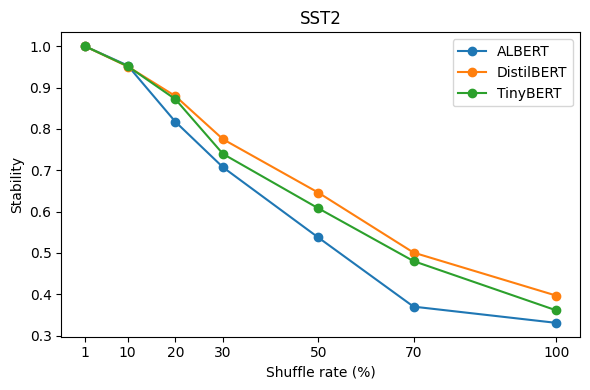

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stability_from_combined(combined_df, RATIOS, title="IMDB"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(6, 4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"] * 100, sub["corr_spearman_mean"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Shuffle rate (%)")
    plt.ylabel("Stability")
    plt.legend()
    
    # --- use RATIOS for x-ticks ---
    plt.xticks([r * 100 for r in RATIOS], [int(r * 100) for r in RATIOS])
    plt.ylim()
    plt.tight_layout()
    plt.show()

# Example usage
plot_stability_from_combined(combined_df, RATIOS, title="SST2")

Faithfulness

In [40]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer

def calculate_comprehensiveness_with_get(df, model_dir, get_attention_and_prob, RATIOS, device=None, max_length=512):
    """
    COMP = mean_q [ p(x) - p(x \ x_top_q%) ], removing top-q% (by attention)
    using the user's get_attention_and_prob(model_dir, text, ...).

    - Removes only non-special tokens (keeps CLS and SEP).
    - Uses the same tokenizer as the model to align indices.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_dir)

    comp_per_ratio = {str(r): [] for r in RATIOS}

    for _, row in tqdm(df.iterrows(), total=len(df)):
        text = row["texts"]

        # Attention & original prob (from your function)
        attn_scores, p_orig = get_attention_and_prob(model_dir, text, device=device, max_length=max_length)

        # Build ids the same way the model will see them
        enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        ids = enc["input_ids"][0]
        seq_len = int(enc["attention_mask"][0].sum().item())

        # Trim to the real sequence len (incl specials)
        ids = ids[:seq_len].tolist()
        attn = np.asarray(attn_scores[:seq_len])  # length matches ids

        # Removable positions are 1..seq_len-2 (exclude CLS at 0 and SEP at -1)
        if seq_len <= 2:
            continue
        removable = np.arange(1, seq_len - 1)
        order = removable[np.argsort(attn[removable])[::-1]]  # most → least important

        for r in RATIOS:
            k = int(round(r * len(removable)))
            k = max(1, min(k, len(removable) - 1))  # avoid 0 / removing all

            remove_idx = set(order[:k].tolist())

            kept = [ids[0]]  # CLS
            for i in range(1, seq_len - 1):
                if i not in remove_idx:
                    kept.append(ids[i])
            kept.append(ids[-1])  # SEP

            reduced_text = tokenizer.decode(kept, skip_special_tokens=True)
            _, p_red = get_attention_and_prob(model_dir, reduced_text, device=device, max_length=max_length)

            comp_per_ratio[str(r)].append(p_orig - p_red)

    rows = []
    for r in RATIOS:
        vals = comp_per_ratio[str(r)]
        if vals:
            rows.append({
                "ratio": r,
                "comprehensiveness": float(np.mean(vals)),
                "std": float(np.std(vals)),
                "n": int(len(vals)),
            })
    return pd.DataFrame(rows).sort_values("ratio").reset_index(drop=True)

In [41]:
model_dir = "D:/master/NLP/models/tinybert_sst2/final"
comp_df = calculate_comprehensiveness_with_get(sst2_df, model_dir, get_attention_and_prob, RATIOS)
print(comp_df)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]

   ratio  comprehensiveness       std   n
0   0.01           0.012447  0.112719  50
1   0.10           0.050593  0.158152  50
2   0.20           0.049198  0.114187  50
3   0.30           0.083485  0.133084  50
4   0.50           0.109992  0.118971  50
5   0.70           0.143988  0.141124  50
6   1.00           0.201757  0.150766  50


In [42]:
import pandas as pd

# 1) Define your model paths (edit as needed)
model_paths = {
    "ALBERT":      "D:/master/NLP/models/albert_sst2/final",
    "DistilBERT":  "D:/master/NLP/models/distilbert_sst2/final",
    "TinyBERT":    "D:/master/NLP/models/tinybert_sst2/final",
}

# 2) Your ratios
# e.g. RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# 3) Collect and combine
all_results = []
for model_name, path in model_paths.items():
    print(f"➡️ Computing Comprehensiveness for {model_name}...")
    comp_df = calculate_comprehensiveness_with_get(
        sst2_df, path, get_attention_and_prob, RATIOS
    )
    # Rename to match the combined schema
    comp_df = comp_df.rename(columns={"ratio": "p", "comprehensiveness": "comprehensiveness"})
    comp_df["model"] = model_name
    all_results.append(comp_df[["model", "p", "comprehensiveness"]])

combined_df = pd.concat(all_results, ignore_index=True)

# 4) Clean + sort (ensure p is numeric if it isn’t already)
combined_df["p"] = pd.to_numeric(combined_df["p"], errors="coerce")
combined_df = combined_df.dropna(subset=["p"]).sort_values(["model", "p"]).reset_index(drop=True)

print(combined_df)


➡️ Computing Comprehensiveness for ALBERT...


100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


➡️ Computing Comprehensiveness for DistilBERT...


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


➡️ Computing Comprehensiveness for TinyBERT...


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

         model     p  comprehensiveness
0       ALBERT  0.01           0.047500
1       ALBERT  0.10           0.059957
2       ALBERT  0.20           0.078555
3       ALBERT  0.30           0.086710
4       ALBERT  0.50           0.128470
5       ALBERT  0.70           0.135003
6       ALBERT  1.00           0.099555
7   DistilBERT  0.01           0.001504
8   DistilBERT  0.10           0.006547
9   DistilBERT  0.20          -0.001205
10  DistilBERT  0.30           0.018848
11  DistilBERT  0.50           0.060925
12  DistilBERT  0.70           0.025475
13  DistilBERT  1.00           0.023734
14    TinyBERT  0.01           0.012447
15    TinyBERT  0.10           0.050593
16    TinyBERT  0.20           0.049198
17    TinyBERT  0.30           0.083485
18    TinyBERT  0.50           0.109992
19    TinyBERT  0.70           0.143988
20    TinyBERT  1.00           0.201757


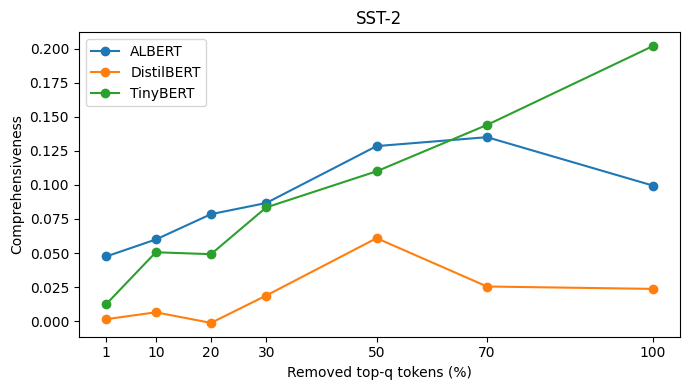

In [43]:
import matplotlib.pyplot as plt

def plot_comprehensiveness(combined_df, RATIOS, title="SST-2"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(7,4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"]*100, sub["comprehensiveness"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Removed top-q tokens (%)")
    plt.ylabel("Comprehensiveness")
    plt.xticks([r*100 for r in RATIOS], [int(r*100) for r in RATIOS])
    plt.legend()
    plt.tight_layout()
    plt.show()

# usage
plot_comprehensiveness(combined_df, RATIOS)

In [44]:
import pandas as pd

# 1) Define your model paths (edit as needed)
model_paths = {
    "ALBERT":      "D:/master/NLP/models/albert_imdb/final",
    "DistilBERT":  "D:/master/NLP/models/distilbert_imdb/final",
    "TinyBERT":    "D:/master/NLP/models/tinybert_imdb/final",
}

# 2) Your ratios
# e.g. RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# 3) Collect and combine
all_results = []
for model_name, path in model_paths.items():
    print(f"➡️ Computing Comprehensiveness for {model_name}...")
    comp_df = calculate_comprehensiveness_with_get(
        imdb_df, path, get_attention_and_prob, RATIOS
    )
    # Rename to match the combined schema
    comp_df = comp_df.rename(columns={"ratio": "p", "comprehensiveness": "comprehensiveness"})
    comp_df["model"] = model_name
    all_results.append(comp_df[["model", "p", "comprehensiveness"]])

combined_df = pd.concat(all_results, ignore_index=True)

# 4) Clean + sort (ensure p is numeric if it isn’t already)
combined_df["p"] = pd.to_numeric(combined_df["p"], errors="coerce")
combined_df = combined_df.dropna(subset=["p"]).sort_values(["model", "p"]).reset_index(drop=True)

print(combined_df)


➡️ Computing Comprehensiveness for ALBERT...


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


➡️ Computing Comprehensiveness for DistilBERT...


100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


➡️ Computing Comprehensiveness for TinyBERT...


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]

         model     p  comprehensiveness
0       ALBERT  0.01          -0.005842
1       ALBERT  0.10           0.032834
2       ALBERT  0.20           0.094955
3       ALBERT  0.30           0.110668
4       ALBERT  0.50           0.139388
5       ALBERT  0.70           0.185858
6       ALBERT  1.00           0.258770
7   DistilBERT  0.01          -0.009519
8   DistilBERT  0.10           0.035180
9   DistilBERT  0.20           0.041563
10  DistilBERT  0.30           0.031851
11  DistilBERT  0.50           0.082395
12  DistilBERT  0.70           0.119590
13  DistilBERT  1.00           0.360115
14    TinyBERT  0.01           0.047792
15    TinyBERT  0.10           0.074316
16    TinyBERT  0.20           0.101005
17    TinyBERT  0.30           0.115144
18    TinyBERT  0.50           0.133478
19    TinyBERT  0.70           0.130990
20    TinyBERT  1.00           0.219646


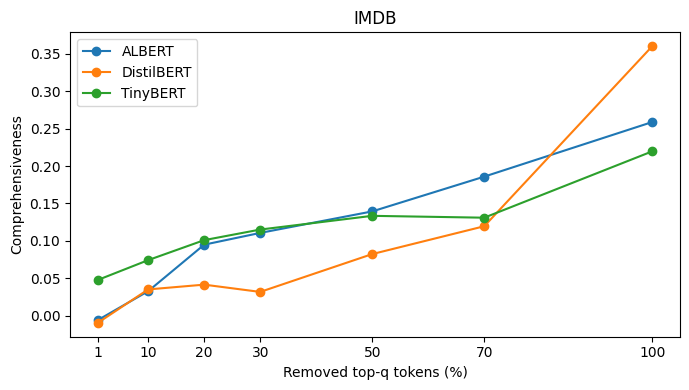

In [45]:
import matplotlib.pyplot as plt

def plot_comprehensiveness(combined_df, RATIOS, title="IMDB"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(7,4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"]*100, sub["comprehensiveness"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Removed top-q tokens (%)")
    plt.ylabel("Comprehensiveness")
    plt.xticks([r*100 for r in RATIOS], [int(r*100) for r in RATIOS])
    plt.legend()
    plt.tight_layout()
    plt.show()

# usage
plot_comprehensiveness(combined_df, RATIOS)

In [47]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer

def calculate_sufficiency_with_get(df, model_dir, get_attention_and_prob, RATIOS, device=None, max_length=512):
    """
    SUFF = mean_q [ p(x) - p(x_top_q%) ], keeping ONLY the top-q% tokens (by attention).
    Uses the same tokenizer as the model to align indices. Keeps CLS & SEP.
    Lower SUFF (smaller drop) = more sufficient important tokens.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_dir)

    suff_per_ratio = {str(r): [] for r in RATIOS}

    for _, row in tqdm(df.iterrows(), total=len(df)):
        text = row["texts"]

        # original attention and prob
        attn_scores, p_orig = get_attention_and_prob(model_dir, text, device=device, max_length=max_length)

        # tokenize exactly as the model sees it
        enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        ids = enc["input_ids"][0]
        seq_len = int(enc["attention_mask"][0].sum().item())

        if seq_len <= 2:
            continue

        # trim & align
        ids = ids[:seq_len].tolist()
        attn = np.asarray(attn_scores[:seq_len])

        # candidate positions to keep: non-special tokens only
        removable = np.arange(1, seq_len - 1)
        # sort by attention descending -> most important first
        order = removable[np.argsort(attn[removable])[::-1]]

        for r in RATIOS:
            k = int(round(r * len(removable)))
            k = max(1, min(k, len(removable)))  # keep at least 1 token

            keep_core = sorted(order[:k].tolist())
            kept = [ids[0]] + [ids[i] for i in keep_core] + [ids[-1]]  # CLS + top-k + SEP

            kept_text = tokenizer.decode(kept, skip_special_tokens=True)
            _, p_keep = get_attention_and_prob(model_dir, kept_text, device=device, max_length=max_length)

            suff = p_orig - p_keep
            suff_per_ratio[str(r)].append(suff)

    # aggregate
    rows = []
    for r in RATIOS:
        vals = suff_per_ratio[str(r)]
        if vals:
            rows.append({
                "ratio": r,
                "sufficiency": float(np.mean(vals)),
                "std": float(np.std(vals)),
                "n": int(len(vals)),
            })
    return pd.DataFrame(rows).sort_values("ratio").reset_index(drop=True)

In [49]:
import pandas as pd

# 1) Define your model paths
model_paths = {
    "ALBERT":      "D:/master/NLP/models/albert_sst2/final",
    "DistilBERT":  "D:/master/NLP/models/distilbert_sst2/final",
    "TinyBERT":    "D:/master/NLP/models/tinybert_sst2/final",
}

# 2) Define your RATIOS (same as before)
# e.g.
# RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# 3) Collect and combine Sufficiency results
all_results = []
for model_name, path in model_paths.items():
    print(f"➡️ Computing Sufficiency for {model_name}...")
    suff_df = calculate_sufficiency_with_get(
        sst2_df, path, get_attention_and_prob, RATIOS
    )
    # Rename columns to match desired schema
    suff_df = suff_df.rename(columns={"ratio": "p", "sufficiency": "sufficiency"})
    suff_df["model"] = model_name
    all_results.append(suff_df[["model", "p", "sufficiency"]])

# 4) Combine all model results into one DataFrame
combined_suff_df = pd.concat(all_results, ignore_index=True)

# 5) Clean + sort
combined_suff_df["p"] = pd.to_numeric(combined_suff_df["p"], errors="coerce")
combined_suff_df = (
    combined_suff_df.dropna(subset=["p"])
    .sort_values(["model", "p"])
    .reset_index(drop=True)
)

print(combined_suff_df)

➡️ Computing Sufficiency for ALBERT...


100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


➡️ Computing Sufficiency for DistilBERT...


100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


➡️ Computing Sufficiency for TinyBERT...


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

         model     p  sufficiency
0       ALBERT  0.01     0.075361
1       ALBERT  0.10     0.034622
2       ALBERT  0.20     0.026540
3       ALBERT  0.30     0.025664
4       ALBERT  0.50     0.001957
5       ALBERT  0.70    -0.005448
6       ALBERT  1.00     0.000209
7   DistilBERT  0.01    -0.011698
8   DistilBERT  0.10     0.001838
9   DistilBERT  0.20     0.008911
10  DistilBERT  0.30     0.004197
11  DistilBERT  0.50     0.011235
12  DistilBERT  0.70     0.001287
13  DistilBERT  1.00     0.000000
14    TinyBERT  0.01     0.085967
15    TinyBERT  0.10     0.034419
16    TinyBERT  0.20     0.040588
17    TinyBERT  0.30     0.034852
18    TinyBERT  0.50     0.001939
19    TinyBERT  0.70    -0.000529
20    TinyBERT  1.00     0.006154


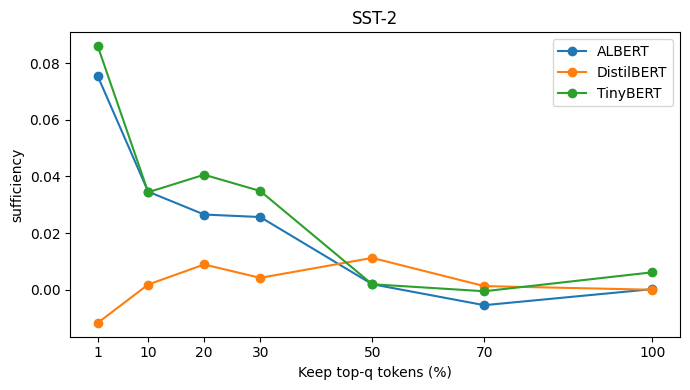

In [52]:
import matplotlib.pyplot as plt

def plot_comprehensiveness(combined_df, RATIOS, title="SST-2"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(7,4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"]*100, sub["sufficiency"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Keep top-q tokens (%)")
    plt.ylabel("sufficiency")
    plt.xticks([r*100 for r in RATIOS], [int(r*100) for r in RATIOS])
    plt.legend()
    plt.tight_layout()
    plt.show()

# usage
plot_comprehensiveness(combined_suff_df, RATIOS)

In [53]:
import pandas as pd

# 1) Define your model paths
model_paths = {
    "ALBERT":      "D:/master/NLP/models/albert_imdb/final",
    "DistilBERT":  "D:/master/NLP/models/distilbert_imdb/final",
    "TinyBERT":    "D:/master/NLP/models/tinybert_imdb/final",
}

# 2) Define your RATIOS (same as before)
# e.g.
# RATIOS = [0.01, 0.10, 0.20, 0.30, 0.50, 0.70, 1.00]

# 3) Collect and combine Sufficiency results
all_results = []
for model_name, path in model_paths.items():
    print(f"➡️ Computing Sufficiency for {model_name}...")
    suff_df = calculate_sufficiency_with_get(
        imdb_df, path, get_attention_and_prob, RATIOS
    )
    # Rename columns to match desired schema
    suff_df = suff_df.rename(columns={"ratio": "p", "sufficiency": "sufficiency"})
    suff_df["model"] = model_name
    all_results.append(suff_df[["model", "p", "sufficiency"]])

# 4) Combine all model results into one DataFrame
combined_suff_df = pd.concat(all_results, ignore_index=True)

# 5) Clean + sort
combined_suff_df["p"] = pd.to_numeric(combined_suff_df["p"], errors="coerce")
combined_suff_df = (
    combined_suff_df.dropna(subset=["p"])
    .sort_values(["model", "p"])
    .reset_index(drop=True)
)

print(combined_suff_df)

➡️ Computing Sufficiency for ALBERT...


100%|██████████| 50/50 [02:12<00:00,  2.66s/it]


➡️ Computing Sufficiency for DistilBERT...


100%|██████████| 50/50 [01:52<00:00,  2.26s/it]


➡️ Computing Sufficiency for TinyBERT...


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]

         model     p  sufficiency
0       ALBERT  0.01     0.023176
1       ALBERT  0.10    -0.003755
2       ALBERT  0.20     0.010733
3       ALBERT  0.30    -0.002299
4       ALBERT  0.50    -0.001078
5       ALBERT  0.70    -0.005529
6       ALBERT  1.00     0.009312
7   DistilBERT  0.01     0.112525
8   DistilBERT  0.10    -0.008799
9   DistilBERT  0.20     0.000782
10  DistilBERT  0.30    -0.001708
11  DistilBERT  0.50    -0.021240
12  DistilBERT  0.70    -0.017214
13  DistilBERT  1.00     0.000000
14    TinyBERT  0.01     0.014849
15    TinyBERT  0.10     0.014363
16    TinyBERT  0.20    -0.004603
17    TinyBERT  0.30    -0.005786
18    TinyBERT  0.50    -0.008075
19    TinyBERT  0.70    -0.009356
20    TinyBERT  1.00     0.000000


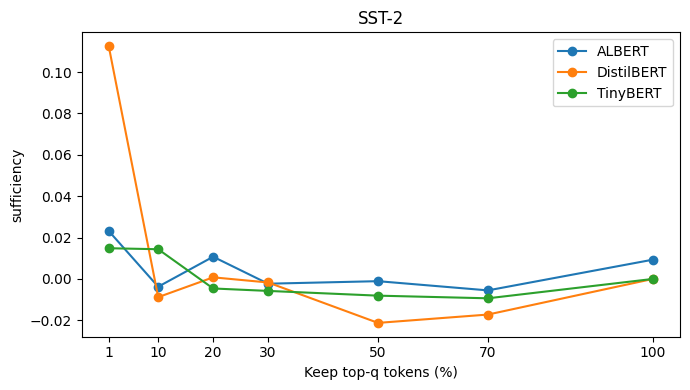

In [54]:
import matplotlib.pyplot as plt

def plot_comprehensiveness(combined_df, RATIOS, title="SST-2"):
    df = combined_df.copy()
    df["p"] = pd.to_numeric(df["p"], errors="coerce")
    df = df.dropna(subset=["p"]).sort_values(["model", "p"])

    plt.figure(figsize=(7,4))
    for model in df["model"].unique():
        sub = df[df["model"] == model]
        plt.plot(sub["p"]*100, sub["sufficiency"], marker="o", label=model)

    plt.title(title)
    plt.xlabel("Keep top-q tokens (%)")
    plt.ylabel("sufficiency")
    plt.xticks([r*100 for r in RATIOS], [int(r*100) for r in RATIOS])
    plt.legend()
    plt.tight_layout()
    plt.show()

# usage
plot_comprehensiveness(combined_suff_df, RATIOS)